<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Для начала установим и загрузим все необходимые библиотеки и посмотрим на наши данные. 

In [1]:
#Install and import all necessary libraries
!pip install pandas
import pandas as pd
from collections import Counter
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
!pip install catboost
import catboost as ctb
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Load data
filepath = 'https://github.com/Viktoriia-Ilina/yandex/blob/main/Churn_Modelling.csv?raw=true'
data = pd.read_csv(filepath)
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Итак у нас есть следующая информация о 10000 клиентов банка:

- RowNumber — индекс строки в данных;
- CustomerId — уникальный идентификатор клиента;
- Surname — фамилия;
- CreditScore — кредитный рейтинг;
- Geography — страна проживания;
- Gender — пол;
- Age — возраст;
- Tenure — сколько лет человек является клиентом банка;
- Balance — баланс на счёте;
- NumOfProducts — количество продуктов банка, используемых клиентом;
- HasCrCard — наличие кредитной карты;
- IsActiveMember — активность клиента;
- EstimatedSalary — предполагаемая зарплата.

И целевой показатедь Exited, обозначающий ушел клиент или остался. 

В целях дальнейшего анализа столбцы 'RowNumber', 'CustomerId' и 'Surname' малоинформативны, поэтому мы можем их удалить. 


In [2]:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 'columns')
data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


Теперь проверим нащи данные на наличие отсутствующих значений и дубликаты.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
data.duplicated().sum()

0

Отлично, можем двигаться дальше. 

## Исследование задачи

Заменим текстовые значения в стобцах 'Geography' и 'Gender' на числовые.

In [5]:
lb = LabelEncoder() 

data['Geography'] = lb.fit_transform(data['Geography'])
data['Gender'] = lb.fit_transform(data['Gender'])

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


Построим корреляционную матрицу и посмотрим какие переменные наиболее тесно связаны с таргетной переменной. 

<AxesSubplot:>

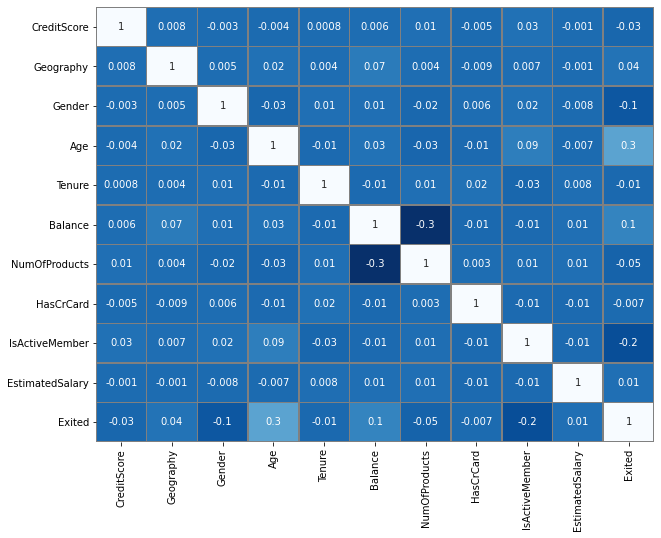

In [6]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(data.corr(), annot = True, fmt = '.1g', cmap = 'Blues_r', cbar = False, linewidths = 0.5, linecolor = 'grey')

Наибольшая корреляция (0.3) наблюдается между возрастом и целевым значением. Это немного странно, так как обычно когда люди становятся старше, они теряют тягу к риску и предпочитают стабильность. Присутствует отрицательная корреляция (-0.2) между активностью пользователя и его желанием отказаться от услуг банка. В то же время наблюдается слабая положительная корреляция между балансом на счёте и таргетной переменной (0.1). В целом все корреляции являются слабыми.

Посмотрим на сбалансированность датасета. Мы видим большой перекос в сторону клиентов, остающихся с банком (80% против 20%). Это типичная проблема в подобного рода задачах и обычно она решается с помощью корректировки данных (undersampling, oversampling, добавление новых реальных данных и т.д.). Однако для начала попробуем произвести расчёты как есть.

In [7]:
data['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Для того чтобы избежать проблемы переобучения модели, разделим наши данные на три группы: обучение, проверка и тестирование.

In [37]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(8000, 10)
(8000,)
(1000, 10)
(1000,)
(1000, 10)
(1000,)


(None, None)

Так наши переменные имеют разные шкалы и отличаются в тысячи раз, то они вносят разный вклад в процесс обучения модели, что может в конечном итоге создать предвзятость. Чтобы этого избежать применим Standard Scaler.

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

В ходе данного проекта мы будем использовать три модели:
- Support vector classifier;
- Random forest classifier;
- Catboost.

Для оценки будут использоваться:
- classification report;
- confusion_matrix; 
- roc - auc score.

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       786
           1       0.77      0.38      0.51       214

    accuracy                           0.84      1000
   macro avg       0.81      0.68      0.71      1000
weighted avg       0.84      0.84      0.82      1000

AUC - ROC score:  0.6763216094742098


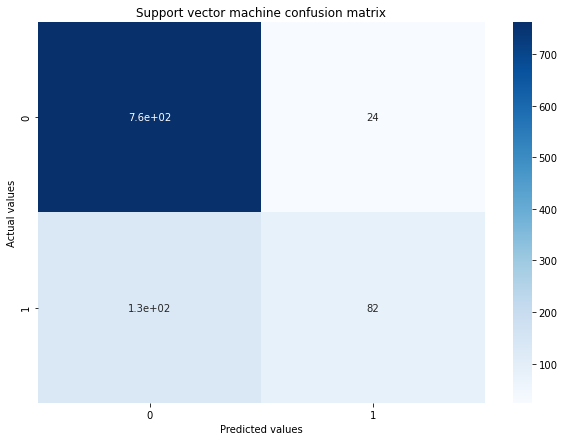

In [39]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       786
           1       0.73      0.48      0.58       214

    accuracy                           0.85      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.84      0.85      0.84      1000

AUC - ROC score:  0.7141447290195239


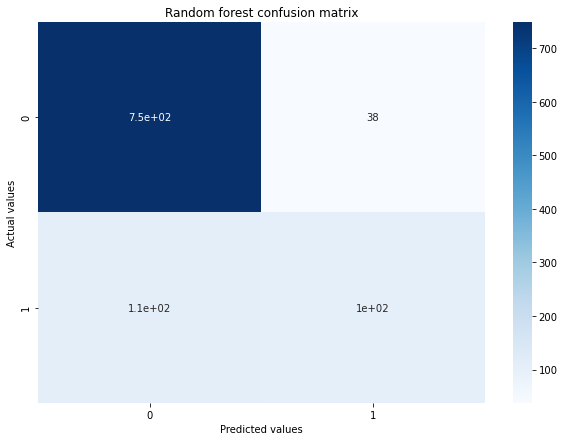

In [40]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

### Catboost

Learning rate set to 0.025035
0:	learn: 0.6731781	total: 3.65ms	remaining: 3.65s
1:	learn: 0.6541255	total: 6.91ms	remaining: 3.45s
2:	learn: 0.6363677	total: 10.3ms	remaining: 3.42s
3:	learn: 0.6189211	total: 14ms	remaining: 3.48s
4:	learn: 0.6029321	total: 17.3ms	remaining: 3.45s
5:	learn: 0.5888791	total: 20.7ms	remaining: 3.42s
6:	learn: 0.5743036	total: 24ms	remaining: 3.4s
7:	learn: 0.5629785	total: 27.3ms	remaining: 3.39s
8:	learn: 0.5501886	total: 30.7ms	remaining: 3.38s
9:	learn: 0.5386719	total: 34ms	remaining: 3.37s
10:	learn: 0.5284524	total: 36.9ms	remaining: 3.31s
11:	learn: 0.5196107	total: 40.3ms	remaining: 3.32s
12:	learn: 0.5110456	total: 43.9ms	remaining: 3.33s
13:	learn: 0.5035970	total: 47.2ms	remaining: 3.32s
14:	learn: 0.4950389	total: 50.5ms	remaining: 3.32s
15:	learn: 0.4874511	total: 53.9ms	remaining: 3.31s
16:	learn: 0.4797868	total: 57.3ms	remaining: 3.31s
17:	learn: 0.4726832	total: 60.6ms	remaining: 3.31s
18:	learn: 0.4671598	total: 63.9ms	remaining: 3.3s


162:	learn: 0.3190785	total: 579ms	remaining: 2.97s
163:	learn: 0.3187839	total: 583ms	remaining: 2.97s
164:	learn: 0.3185512	total: 586ms	remaining: 2.97s
165:	learn: 0.3184077	total: 589ms	remaining: 2.96s
166:	learn: 0.3182419	total: 593ms	remaining: 2.96s
167:	learn: 0.3180584	total: 596ms	remaining: 2.95s
168:	learn: 0.3179012	total: 600ms	remaining: 2.95s
169:	learn: 0.3177318	total: 603ms	remaining: 2.94s
170:	learn: 0.3175428	total: 606ms	remaining: 2.94s
171:	learn: 0.3173658	total: 610ms	remaining: 2.94s
172:	learn: 0.3171354	total: 614ms	remaining: 2.93s
173:	learn: 0.3168869	total: 617ms	remaining: 2.93s
174:	learn: 0.3166259	total: 620ms	remaining: 2.92s
175:	learn: 0.3164232	total: 624ms	remaining: 2.92s
176:	learn: 0.3162641	total: 627ms	remaining: 2.91s
177:	learn: 0.3161342	total: 630ms	remaining: 2.91s
178:	learn: 0.3159949	total: 633ms	remaining: 2.9s
179:	learn: 0.3158329	total: 637ms	remaining: 2.9s
180:	learn: 0.3156194	total: 640ms	remaining: 2.9s
181:	learn: 0.3

334:	learn: 0.2953202	total: 1.16s	remaining: 2.29s
335:	learn: 0.2952010	total: 1.16s	remaining: 2.29s
336:	learn: 0.2950632	total: 1.16s	remaining: 2.29s
337:	learn: 0.2949465	total: 1.17s	remaining: 2.29s
338:	learn: 0.2948680	total: 1.17s	remaining: 2.28s
339:	learn: 0.2947477	total: 1.17s	remaining: 2.28s
340:	learn: 0.2946775	total: 1.18s	remaining: 2.27s
341:	learn: 0.2945474	total: 1.18s	remaining: 2.27s
342:	learn: 0.2944611	total: 1.18s	remaining: 2.27s
343:	learn: 0.2943215	total: 1.19s	remaining: 2.26s
344:	learn: 0.2942181	total: 1.19s	remaining: 2.26s
345:	learn: 0.2941378	total: 1.19s	remaining: 2.26s
346:	learn: 0.2939779	total: 1.2s	remaining: 2.25s
347:	learn: 0.2938768	total: 1.2s	remaining: 2.25s
348:	learn: 0.2936921	total: 1.2s	remaining: 2.24s
349:	learn: 0.2935279	total: 1.21s	remaining: 2.24s
350:	learn: 0.2934690	total: 1.21s	remaining: 2.24s
351:	learn: 0.2933779	total: 1.21s	remaining: 2.23s
352:	learn: 0.2933012	total: 1.22s	remaining: 2.23s
353:	learn: 0.2

507:	learn: 0.2761296	total: 1.74s	remaining: 1.68s
508:	learn: 0.2760141	total: 1.74s	remaining: 1.68s
509:	learn: 0.2759371	total: 1.74s	remaining: 1.68s
510:	learn: 0.2758234	total: 1.75s	remaining: 1.67s
511:	learn: 0.2757066	total: 1.75s	remaining: 1.67s
512:	learn: 0.2756160	total: 1.75s	remaining: 1.67s
513:	learn: 0.2754962	total: 1.76s	remaining: 1.66s
514:	learn: 0.2753993	total: 1.76s	remaining: 1.66s
515:	learn: 0.2753121	total: 1.76s	remaining: 1.66s
516:	learn: 0.2751816	total: 1.77s	remaining: 1.65s
517:	learn: 0.2751081	total: 1.77s	remaining: 1.65s
518:	learn: 0.2750242	total: 1.77s	remaining: 1.64s
519:	learn: 0.2749260	total: 1.78s	remaining: 1.64s
520:	learn: 0.2748512	total: 1.78s	remaining: 1.64s
521:	learn: 0.2747735	total: 1.78s	remaining: 1.63s
522:	learn: 0.2746569	total: 1.79s	remaining: 1.63s
523:	learn: 0.2745605	total: 1.79s	remaining: 1.63s
524:	learn: 0.2744989	total: 1.79s	remaining: 1.62s
525:	learn: 0.2744125	total: 1.8s	remaining: 1.62s
526:	learn: 0

680:	learn: 0.2597274	total: 2.31s	remaining: 1.08s
681:	learn: 0.2596483	total: 2.32s	remaining: 1.08s
682:	learn: 0.2595773	total: 2.32s	remaining: 1.08s
683:	learn: 0.2594486	total: 2.32s	remaining: 1.07s
684:	learn: 0.2593593	total: 2.33s	remaining: 1.07s
685:	learn: 0.2592489	total: 2.33s	remaining: 1.07s
686:	learn: 0.2591669	total: 2.33s	remaining: 1.06s
687:	learn: 0.2590462	total: 2.34s	remaining: 1.06s
688:	learn: 0.2589725	total: 2.34s	remaining: 1.06s
689:	learn: 0.2589066	total: 2.34s	remaining: 1.05s
690:	learn: 0.2588027	total: 2.35s	remaining: 1.05s
691:	learn: 0.2587080	total: 2.35s	remaining: 1.05s
692:	learn: 0.2586253	total: 2.35s	remaining: 1.04s
693:	learn: 0.2585360	total: 2.36s	remaining: 1.04s
694:	learn: 0.2584270	total: 2.36s	remaining: 1.03s
695:	learn: 0.2583419	total: 2.36s	remaining: 1.03s
696:	learn: 0.2582589	total: 2.37s	remaining: 1.03s
697:	learn: 0.2581602	total: 2.37s	remaining: 1.02s
698:	learn: 0.2580614	total: 2.37s	remaining: 1.02s
699:	learn: 

849:	learn: 0.2461522	total: 2.89s	remaining: 511ms
850:	learn: 0.2460658	total: 2.9s	remaining: 507ms
851:	learn: 0.2459481	total: 2.9s	remaining: 504ms
852:	learn: 0.2458675	total: 2.9s	remaining: 500ms
853:	learn: 0.2457821	total: 2.91s	remaining: 497ms
854:	learn: 0.2456712	total: 2.91s	remaining: 494ms
855:	learn: 0.2456079	total: 2.91s	remaining: 490ms
856:	learn: 0.2455551	total: 2.92s	remaining: 487ms
857:	learn: 0.2455001	total: 2.92s	remaining: 484ms
858:	learn: 0.2454361	total: 2.92s	remaining: 480ms
859:	learn: 0.2453050	total: 2.93s	remaining: 477ms
860:	learn: 0.2452460	total: 2.93s	remaining: 473ms
861:	learn: 0.2451602	total: 2.94s	remaining: 470ms
862:	learn: 0.2450747	total: 2.94s	remaining: 467ms
863:	learn: 0.2449552	total: 2.94s	remaining: 463ms
864:	learn: 0.2448900	total: 2.94s	remaining: 460ms
865:	learn: 0.2448113	total: 2.95s	remaining: 456ms
866:	learn: 0.2447661	total: 2.95s	remaining: 453ms
867:	learn: 0.2446816	total: 2.96s	remaining: 450ms
868:	learn: 0.2

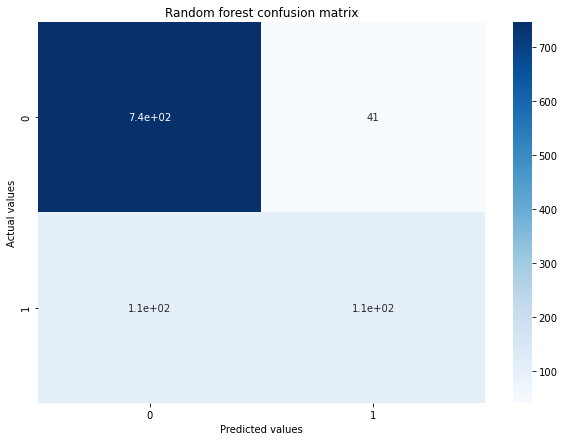

In [41]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Все три модели имеют высокую точность 84-85%, однако в данной ситуации (несбалансированность датасета) метрика точности является необъективной, так как модели хорошо определяют класс большинства и очень плохо работают для меньшинства. Особенно сильно это проявляется у Support Vector Classifier, где показатель F1 составил 51%. 

## Борьба с дисбалансом

### SMOTE

Для того чтобы справиться с проблемой несбалансированного датасета применим технику SMOTE, которая генерирует дополнительные синтетические значения для меньшинства.

In [42]:
counter = Counter(Y_train)
print('Inintial training data',counter)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)
print('After resampling',counter)

Inintial training data Counter({0: 6363, 1: 1637})
After resampling Counter({0: 6363, 1: 6363})


              precision    recall  f1-score   support

           0       0.91      0.80      0.85       786
           1       0.49      0.72      0.59       214

    accuracy                           0.78      1000
   macro avg       0.70      0.76      0.72      1000
weighted avg       0.82      0.78      0.80      1000

AUC - ROC score:  0.7610044945423414


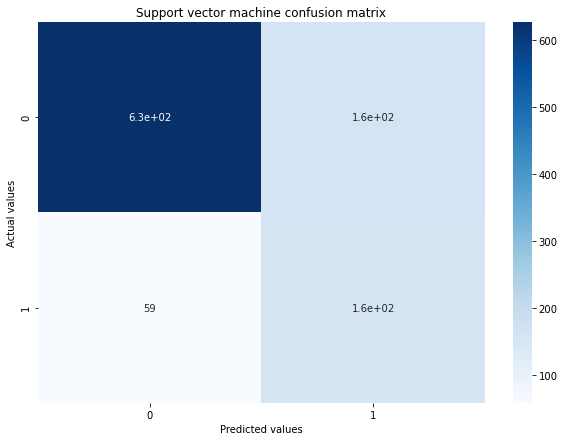

In [43]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       786
           1       0.61      0.59      0.60       214

    accuracy                           0.83      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.83      0.83      0.83      1000

AUC - ROC score:  0.7452022544053649


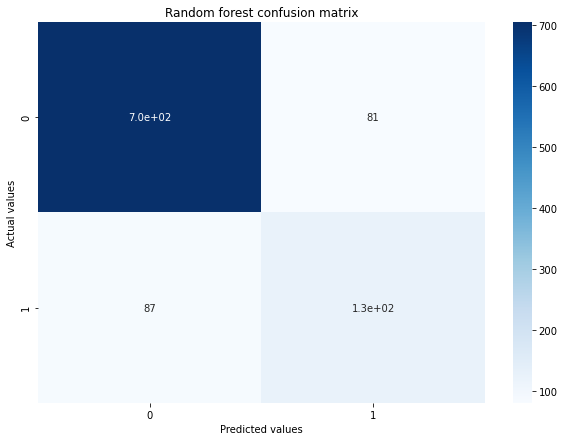

In [44]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Learning rate set to 0.030524
0:	learn: 0.6752328	total: 7.24ms	remaining: 7.23s
1:	learn: 0.6590877	total: 13.9ms	remaining: 6.94s
2:	learn: 0.6441951	total: 21.4ms	remaining: 7.09s
3:	learn: 0.6297093	total: 28ms	remaining: 6.96s
4:	learn: 0.6163642	total: 34.4ms	remaining: 6.86s
5:	learn: 0.6053355	total: 41ms	remaining: 6.78s
6:	learn: 0.5936789	total: 48.2ms	remaining: 6.83s
7:	learn: 0.5824582	total: 55.5ms	remaining: 6.89s
8:	learn: 0.5724027	total: 62ms	remaining: 6.83s
9:	learn: 0.5631691	total: 73.7ms	remaining: 7.3s
10:	learn: 0.5544180	total: 80.2ms	remaining: 7.21s
11:	learn: 0.5471106	total: 86.3ms	remaining: 7.11s
12:	learn: 0.5392988	total: 94.1ms	remaining: 7.14s
13:	learn: 0.5328677	total: 101ms	remaining: 7.09s
14:	learn: 0.5263132	total: 107ms	remaining: 7.04s
15:	learn: 0.5203086	total: 114ms	remaining: 7.04s
16:	learn: 0.5151649	total: 121ms	remaining: 6.99s
17:	learn: 0.5110337	total: 127ms	remaining: 6.95s
18:	learn: 0.5060808	total: 134ms	remaining: 6.93s
19:	l

161:	learn: 0.3165623	total: 994ms	remaining: 5.14s
162:	learn: 0.3163202	total: 999ms	remaining: 5.13s
163:	learn: 0.3155575	total: 1.01s	remaining: 5.13s
164:	learn: 0.3140326	total: 1.01s	remaining: 5.12s
165:	learn: 0.3137129	total: 1.02s	remaining: 5.11s
166:	learn: 0.3133207	total: 1.02s	remaining: 5.1s
167:	learn: 0.3128991	total: 1.03s	remaining: 5.1s
168:	learn: 0.3125635	total: 1.03s	remaining: 5.09s
169:	learn: 0.3121708	total: 1.04s	remaining: 5.08s
170:	learn: 0.3116134	total: 1.05s	remaining: 5.07s
171:	learn: 0.3111740	total: 1.05s	remaining: 5.07s
172:	learn: 0.3108641	total: 1.06s	remaining: 5.06s
173:	learn: 0.3105720	total: 1.06s	remaining: 5.05s
174:	learn: 0.3103753	total: 1.07s	remaining: 5.04s
175:	learn: 0.3100367	total: 1.07s	remaining: 5.04s
176:	learn: 0.3093396	total: 1.08s	remaining: 5.03s
177:	learn: 0.3091510	total: 1.09s	remaining: 5.02s
178:	learn: 0.3089199	total: 1.09s	remaining: 5.01s
179:	learn: 0.3085028	total: 1.1s	remaining: 5s
180:	learn: 0.3072

333:	learn: 0.2528297	total: 1.99s	remaining: 3.96s
334:	learn: 0.2525856	total: 2s	remaining: 3.96s
335:	learn: 0.2524071	total: 2s	remaining: 3.95s
336:	learn: 0.2516020	total: 2.01s	remaining: 3.95s
337:	learn: 0.2513915	total: 2.01s	remaining: 3.94s
338:	learn: 0.2510996	total: 2.02s	remaining: 3.94s
339:	learn: 0.2509897	total: 2.02s	remaining: 3.93s
340:	learn: 0.2508787	total: 2.03s	remaining: 3.92s
341:	learn: 0.2507522	total: 2.04s	remaining: 3.92s
342:	learn: 0.2503261	total: 2.04s	remaining: 3.91s
343:	learn: 0.2501821	total: 2.05s	remaining: 3.9s
344:	learn: 0.2500567	total: 2.05s	remaining: 3.9s
345:	learn: 0.2499781	total: 2.06s	remaining: 3.89s
346:	learn: 0.2498375	total: 2.06s	remaining: 3.88s
347:	learn: 0.2497149	total: 2.07s	remaining: 3.88s
348:	learn: 0.2490841	total: 2.07s	remaining: 3.87s
349:	learn: 0.2487483	total: 2.08s	remaining: 3.86s
350:	learn: 0.2486451	total: 2.08s	remaining: 3.85s
351:	learn: 0.2479377	total: 2.09s	remaining: 3.85s
352:	learn: 0.247754

504:	learn: 0.2182205	total: 2.98s	remaining: 2.92s
505:	learn: 0.2181188	total: 2.99s	remaining: 2.92s
506:	learn: 0.2179505	total: 2.99s	remaining: 2.91s
507:	learn: 0.2178218	total: 3s	remaining: 2.9s
508:	learn: 0.2175908	total: 3.01s	remaining: 2.9s
509:	learn: 0.2174933	total: 3.01s	remaining: 2.9s
510:	learn: 0.2172161	total: 3.02s	remaining: 2.89s
511:	learn: 0.2170725	total: 3.03s	remaining: 2.88s
512:	learn: 0.2169122	total: 3.03s	remaining: 2.88s
513:	learn: 0.2168236	total: 3.04s	remaining: 2.87s
514:	learn: 0.2167353	total: 3.04s	remaining: 2.87s
515:	learn: 0.2166445	total: 3.05s	remaining: 2.86s
516:	learn: 0.2165502	total: 3.06s	remaining: 2.85s
517:	learn: 0.2162618	total: 3.06s	remaining: 2.85s
518:	learn: 0.2160052	total: 3.07s	remaining: 2.84s
519:	learn: 0.2159332	total: 3.07s	remaining: 2.84s
520:	learn: 0.2158365	total: 3.08s	remaining: 2.83s
521:	learn: 0.2157657	total: 3.08s	remaining: 2.82s
522:	learn: 0.2156478	total: 3.09s	remaining: 2.82s
523:	learn: 0.2155

689:	learn: 0.1991331	total: 4.18s	remaining: 1.88s
690:	learn: 0.1990858	total: 4.18s	remaining: 1.87s
691:	learn: 0.1990072	total: 4.19s	remaining: 1.87s
692:	learn: 0.1989366	total: 4.2s	remaining: 1.86s
693:	learn: 0.1988559	total: 4.21s	remaining: 1.85s
694:	learn: 0.1988011	total: 4.21s	remaining: 1.85s
695:	learn: 0.1986935	total: 4.22s	remaining: 1.84s
696:	learn: 0.1986447	total: 4.23s	remaining: 1.84s
697:	learn: 0.1985774	total: 4.23s	remaining: 1.83s
698:	learn: 0.1984351	total: 4.24s	remaining: 1.82s
699:	learn: 0.1983515	total: 4.25s	remaining: 1.82s
700:	learn: 0.1982493	total: 4.25s	remaining: 1.81s
701:	learn: 0.1981202	total: 4.26s	remaining: 1.81s
702:	learn: 0.1980583	total: 4.27s	remaining: 1.8s
703:	learn: 0.1979762	total: 4.27s	remaining: 1.8s
704:	learn: 0.1979165	total: 4.28s	remaining: 1.79s
705:	learn: 0.1978324	total: 4.29s	remaining: 1.78s
706:	learn: 0.1977779	total: 4.29s	remaining: 1.78s
707:	learn: 0.1976128	total: 4.3s	remaining: 1.77s
708:	learn: 0.19

866:	learn: 0.1843246	total: 5.36s	remaining: 823ms
867:	learn: 0.1842525	total: 5.37s	remaining: 817ms
868:	learn: 0.1841458	total: 5.38s	remaining: 811ms
869:	learn: 0.1840929	total: 5.38s	remaining: 805ms
870:	learn: 0.1840305	total: 5.39s	remaining: 799ms
871:	learn: 0.1839553	total: 5.4s	remaining: 793ms
872:	learn: 0.1838814	total: 5.41s	remaining: 786ms
873:	learn: 0.1838184	total: 5.41s	remaining: 780ms
874:	learn: 0.1837509	total: 5.42s	remaining: 774ms
875:	learn: 0.1836512	total: 5.43s	remaining: 768ms
876:	learn: 0.1835636	total: 5.43s	remaining: 762ms
877:	learn: 0.1835099	total: 5.44s	remaining: 756ms
878:	learn: 0.1834489	total: 5.45s	remaining: 750ms
879:	learn: 0.1834012	total: 5.45s	remaining: 744ms
880:	learn: 0.1833085	total: 5.46s	remaining: 737ms
881:	learn: 0.1831841	total: 5.47s	remaining: 731ms
882:	learn: 0.1831157	total: 5.47s	remaining: 725ms
883:	learn: 0.1830493	total: 5.48s	remaining: 719ms
884:	learn: 0.1829998	total: 5.49s	remaining: 713ms
885:	learn: 0

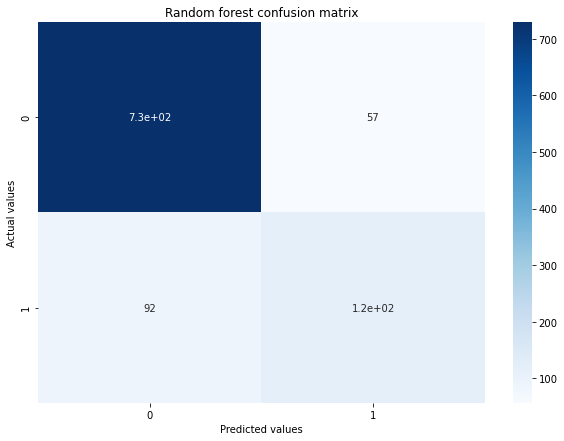

In [45]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Мы видим значительное улучшение F1-score и AUC-ROC score, особенно в случае Support Vector Classifier.

### SMOTE + Tomek Links

Теперь попробуем другую методику SMOTE + Tomek Links. Это гибридная методика, которая сочетает в себе undersampling and oversampling техники.

In [46]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


counter = Counter(Y_train)
print('Inintial training data',counter)
smote = SMOTETomek()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)
print('After resampling',counter)

Inintial training data Counter({0: 6363, 1: 1637})
After resampling Counter({0: 6265, 1: 6265})


              precision    recall  f1-score   support

           0       0.91      0.78      0.84       786
           1       0.47      0.71      0.57       214

    accuracy                           0.77      1000
   macro avg       0.69      0.75      0.71      1000
weighted avg       0.82      0.77      0.78      1000

AUC - ROC score:  0.7486980095598202


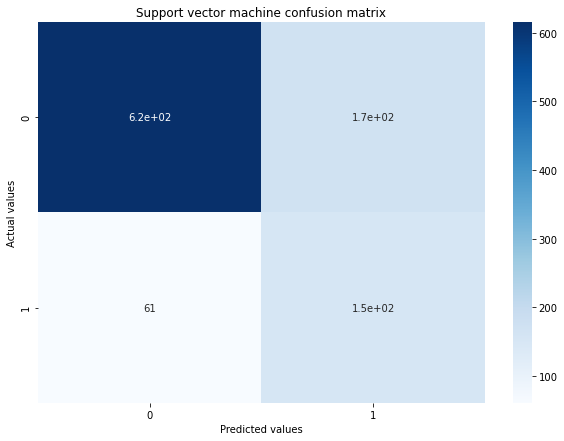

In [47]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       786
           1       0.58      0.58      0.58       214

    accuracy                           0.82      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.82      0.82      0.82      1000

AUC - ROC score:  0.7354402986849302


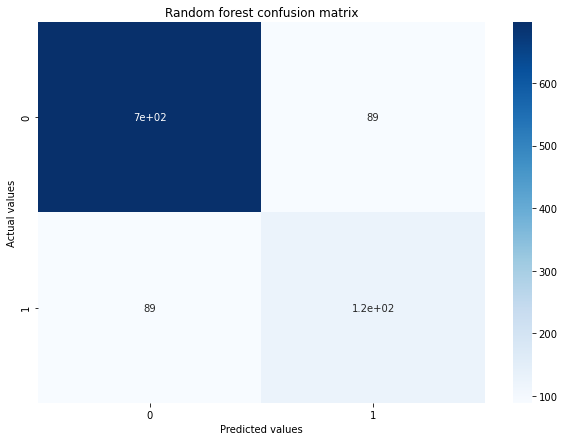

In [48]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Learning rate set to 0.030322
0:	learn: 0.6747082	total: 6.24ms	remaining: 6.23s
1:	learn: 0.6578102	total: 12.2ms	remaining: 6.07s
2:	learn: 0.6432500	total: 18.7ms	remaining: 6.22s
3:	learn: 0.6281449	total: 24.5ms	remaining: 6.09s
4:	learn: 0.6143839	total: 30.1ms	remaining: 6s
5:	learn: 0.6024175	total: 35.8ms	remaining: 5.93s
6:	learn: 0.5909065	total: 41.5ms	remaining: 5.89s
7:	learn: 0.5800221	total: 47.4ms	remaining: 5.87s
8:	learn: 0.5701969	total: 53.2ms	remaining: 5.86s
9:	learn: 0.5606005	total: 59ms	remaining: 5.84s
10:	learn: 0.5522086	total: 64.9ms	remaining: 5.83s
11:	learn: 0.5445331	total: 70.8ms	remaining: 5.83s
12:	learn: 0.5373411	total: 76.7ms	remaining: 5.82s
13:	learn: 0.5312445	total: 82.9ms	remaining: 5.84s
14:	learn: 0.5248491	total: 88.8ms	remaining: 5.83s
15:	learn: 0.5187158	total: 94.6ms	remaining: 5.82s
16:	learn: 0.5129831	total: 103ms	remaining: 5.93s
17:	learn: 0.5081673	total: 108ms	remaining: 5.91s
18:	learn: 0.5020513	total: 114ms	remaining: 5.9s
1

169:	learn: 0.3096616	total: 992ms	remaining: 4.84s
170:	learn: 0.3080217	total: 998ms	remaining: 4.84s
171:	learn: 0.3076918	total: 1s	remaining: 4.83s
172:	learn: 0.3072848	total: 1.01s	remaining: 4.83s
173:	learn: 0.3070838	total: 1.01s	remaining: 4.82s
174:	learn: 0.3068302	total: 1.02s	remaining: 4.81s
175:	learn: 0.3063612	total: 1.03s	remaining: 4.8s
176:	learn: 0.3058539	total: 1.03s	remaining: 4.8s
177:	learn: 0.3052806	total: 1.04s	remaining: 4.79s
178:	learn: 0.3050302	total: 1.04s	remaining: 4.78s
179:	learn: 0.3047645	total: 1.05s	remaining: 4.78s
180:	learn: 0.3045785	total: 1.05s	remaining: 4.77s
181:	learn: 0.3043673	total: 1.06s	remaining: 4.76s
182:	learn: 0.3033633	total: 1.06s	remaining: 4.76s
183:	learn: 0.3031702	total: 1.07s	remaining: 4.76s
184:	learn: 0.3028461	total: 1.08s	remaining: 4.75s
185:	learn: 0.3021619	total: 1.08s	remaining: 4.74s
186:	learn: 0.3008581	total: 1.09s	remaining: 4.75s
187:	learn: 0.3006362	total: 1.1s	remaining: 4.74s
188:	learn: 0.3004

337:	learn: 0.2485061	total: 1.97s	remaining: 3.86s
338:	learn: 0.2483607	total: 1.98s	remaining: 3.86s
339:	learn: 0.2481106	total: 1.98s	remaining: 3.85s
340:	learn: 0.2478945	total: 1.99s	remaining: 3.85s
341:	learn: 0.2476689	total: 2s	remaining: 3.84s
342:	learn: 0.2475386	total: 2s	remaining: 3.83s
343:	learn: 0.2471961	total: 2.01s	remaining: 3.83s
344:	learn: 0.2469949	total: 2.01s	remaining: 3.82s
345:	learn: 0.2465783	total: 2.02s	remaining: 3.82s
346:	learn: 0.2464488	total: 2.03s	remaining: 3.81s
347:	learn: 0.2462595	total: 2.03s	remaining: 3.81s
348:	learn: 0.2461258	total: 2.04s	remaining: 3.8s
349:	learn: 0.2457914	total: 2.04s	remaining: 3.8s
350:	learn: 0.2453768	total: 2.05s	remaining: 3.79s
351:	learn: 0.2448493	total: 2.06s	remaining: 3.78s
352:	learn: 0.2446181	total: 2.06s	remaining: 3.78s
353:	learn: 0.2443420	total: 2.07s	remaining: 3.77s
354:	learn: 0.2440632	total: 2.07s	remaining: 3.77s
355:	learn: 0.2438092	total: 2.08s	remaining: 3.76s
356:	learn: 0.242896

498:	learn: 0.2157765	total: 2.96s	remaining: 2.98s
499:	learn: 0.2155555	total: 2.97s	remaining: 2.97s
500:	learn: 0.2154356	total: 2.98s	remaining: 2.96s
501:	learn: 0.2152768	total: 2.98s	remaining: 2.96s
502:	learn: 0.2151477	total: 2.99s	remaining: 2.95s
503:	learn: 0.2150750	total: 3s	remaining: 2.95s
504:	learn: 0.2149724	total: 3s	remaining: 2.94s
505:	learn: 0.2148098	total: 3.01s	remaining: 2.94s
506:	learn: 0.2147348	total: 3.01s	remaining: 2.93s
507:	learn: 0.2146317	total: 3.02s	remaining: 2.92s
508:	learn: 0.2145398	total: 3.02s	remaining: 2.92s
509:	learn: 0.2144428	total: 3.03s	remaining: 2.91s
510:	learn: 0.2142831	total: 3.04s	remaining: 2.9s
511:	learn: 0.2140962	total: 3.04s	remaining: 2.9s
512:	learn: 0.2140520	total: 3.05s	remaining: 2.89s
513:	learn: 0.2139269	total: 3.05s	remaining: 2.88s
514:	learn: 0.2137478	total: 3.06s	remaining: 2.88s
515:	learn: 0.2136554	total: 3.06s	remaining: 2.87s
516:	learn: 0.2135216	total: 3.07s	remaining: 2.87s
517:	learn: 0.213423

661:	learn: 0.1952632	total: 3.96s	remaining: 2.02s
662:	learn: 0.1951853	total: 3.96s	remaining: 2.02s
663:	learn: 0.1951351	total: 3.97s	remaining: 2.01s
664:	learn: 0.1950293	total: 3.98s	remaining: 2s
665:	learn: 0.1949839	total: 3.98s	remaining: 2s
666:	learn: 0.1948693	total: 3.99s	remaining: 1.99s
667:	learn: 0.1948026	total: 4s	remaining: 1.99s
668:	learn: 0.1947487	total: 4.01s	remaining: 1.98s
669:	learn: 0.1946567	total: 4.01s	remaining: 1.98s
670:	learn: 0.1946006	total: 4.02s	remaining: 1.97s
671:	learn: 0.1944734	total: 4.03s	remaining: 1.97s
672:	learn: 0.1943846	total: 4.03s	remaining: 1.96s
673:	learn: 0.1943199	total: 4.04s	remaining: 1.95s
674:	learn: 0.1942770	total: 4.05s	remaining: 1.95s
675:	learn: 0.1941741	total: 4.05s	remaining: 1.94s
676:	learn: 0.1940874	total: 4.06s	remaining: 1.94s
677:	learn: 0.1939907	total: 4.07s	remaining: 1.93s
678:	learn: 0.1939130	total: 4.07s	remaining: 1.93s
679:	learn: 0.1938452	total: 4.08s	remaining: 1.92s
680:	learn: 0.1938062

840:	learn: 0.1795024	total: 5.15s	remaining: 974ms
841:	learn: 0.1794310	total: 5.16s	remaining: 968ms
842:	learn: 0.1793983	total: 5.17s	remaining: 962ms
843:	learn: 0.1793505	total: 5.17s	remaining: 956ms
844:	learn: 0.1791782	total: 5.18s	remaining: 950ms
845:	learn: 0.1791144	total: 5.18s	remaining: 944ms
846:	learn: 0.1790451	total: 5.19s	remaining: 938ms
847:	learn: 0.1789877	total: 5.2s	remaining: 932ms
848:	learn: 0.1789232	total: 5.2s	remaining: 925ms
849:	learn: 0.1788714	total: 5.21s	remaining: 919ms
850:	learn: 0.1788033	total: 5.21s	remaining: 913ms
851:	learn: 0.1787348	total: 5.22s	remaining: 907ms
852:	learn: 0.1786956	total: 5.23s	remaining: 901ms
853:	learn: 0.1786553	total: 5.23s	remaining: 895ms
854:	learn: 0.1785924	total: 5.24s	remaining: 889ms
855:	learn: 0.1784046	total: 5.25s	remaining: 883ms
856:	learn: 0.1782916	total: 5.25s	remaining: 877ms
857:	learn: 0.1782073	total: 5.26s	remaining: 870ms
858:	learn: 0.1781314	total: 5.27s	remaining: 864ms
859:	learn: 0.

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       786
           1       0.68      0.55      0.60       214

    accuracy                           0.85      1000
   macro avg       0.78      0.74      0.75      1000
weighted avg       0.84      0.85      0.84      1000

AUC - ROC score:  0.7377410763120973


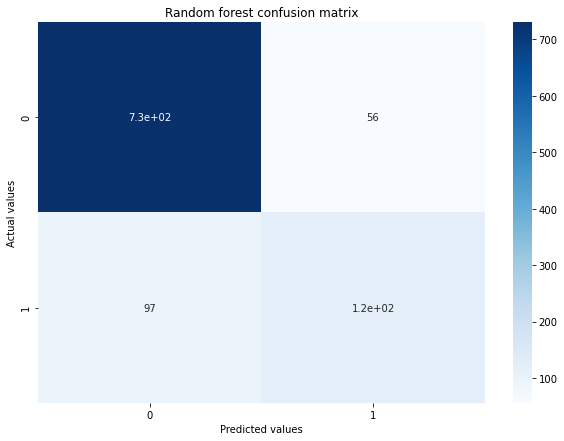

In [49]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Результаты оказались хуже, чем при использовании простого SMOTE, однако в любом случае результат для Support Vector Classifier значительно лучше, чем при несбалансированности.

## Тестирование модели

Запустим модель с наилучшими показателями (Catboost) на тестовом наборе.

Learning rate set to 0.030524
0:	learn: 0.6763591	total: 6.79ms	remaining: 6.78s
1:	learn: 0.6591313	total: 13.4ms	remaining: 6.71s
2:	learn: 0.6437418	total: 20.9ms	remaining: 6.94s
3:	learn: 0.6294400	total: 27.6ms	remaining: 6.87s
4:	learn: 0.6155019	total: 34ms	remaining: 6.76s
5:	learn: 0.6029333	total: 40.5ms	remaining: 6.72s
6:	learn: 0.5935843	total: 47ms	remaining: 6.66s
7:	learn: 0.5829400	total: 53.6ms	remaining: 6.65s
8:	learn: 0.5725795	total: 60.3ms	remaining: 6.64s
9:	learn: 0.5629852	total: 67.1ms	remaining: 6.64s
10:	learn: 0.5538321	total: 73.8ms	remaining: 6.64s
11:	learn: 0.5451135	total: 80.7ms	remaining: 6.65s
12:	learn: 0.5382118	total: 87.4ms	remaining: 6.63s
13:	learn: 0.5320115	total: 94.4ms	remaining: 6.65s
14:	learn: 0.5253734	total: 101ms	remaining: 6.65s
15:	learn: 0.5194320	total: 108ms	remaining: 6.64s
16:	learn: 0.5141614	total: 115ms	remaining: 6.63s
17:	learn: 0.5097243	total: 121ms	remaining: 6.62s
18:	learn: 0.5043823	total: 128ms	remaining: 6.63s
1

185:	learn: 0.3112870	total: 1.2s	remaining: 5.24s
186:	learn: 0.3107046	total: 1.2s	remaining: 5.23s
187:	learn: 0.3103744	total: 1.21s	remaining: 5.22s
188:	learn: 0.3100270	total: 1.22s	remaining: 5.21s
189:	learn: 0.3093715	total: 1.22s	remaining: 5.21s
190:	learn: 0.3080471	total: 1.23s	remaining: 5.2s
191:	learn: 0.3073978	total: 1.24s	remaining: 5.2s
192:	learn: 0.3070569	total: 1.24s	remaining: 5.2s
193:	learn: 0.3068379	total: 1.25s	remaining: 5.19s
194:	learn: 0.3062880	total: 1.25s	remaining: 5.18s
195:	learn: 0.3058139	total: 1.26s	remaining: 5.17s
196:	learn: 0.3044857	total: 1.26s	remaining: 5.16s
197:	learn: 0.3029189	total: 1.27s	remaining: 5.15s
198:	learn: 0.3022791	total: 1.28s	remaining: 5.14s
199:	learn: 0.3018909	total: 1.28s	remaining: 5.13s
200:	learn: 0.3016082	total: 1.29s	remaining: 5.12s
201:	learn: 0.3015086	total: 1.29s	remaining: 5.11s
202:	learn: 0.3012111	total: 1.3s	remaining: 5.11s
203:	learn: 0.3009961	total: 1.31s	remaining: 5.1s
204:	learn: 0.30044

348:	learn: 0.2503820	total: 2.19s	remaining: 4.08s
349:	learn: 0.2498458	total: 2.19s	remaining: 4.08s
350:	learn: 0.2493148	total: 2.2s	remaining: 4.07s
351:	learn: 0.2487375	total: 2.21s	remaining: 4.06s
352:	learn: 0.2485146	total: 2.21s	remaining: 4.06s
353:	learn: 0.2477143	total: 2.22s	remaining: 4.05s
354:	learn: 0.2474395	total: 2.23s	remaining: 4.05s
355:	learn: 0.2473160	total: 2.23s	remaining: 4.04s
356:	learn: 0.2470958	total: 2.24s	remaining: 4.04s
357:	learn: 0.2467255	total: 2.25s	remaining: 4.03s
358:	learn: 0.2464039	total: 2.25s	remaining: 4.02s
359:	learn: 0.2462444	total: 2.26s	remaining: 4.02s
360:	learn: 0.2458973	total: 2.27s	remaining: 4.01s
361:	learn: 0.2455832	total: 2.27s	remaining: 4.01s
362:	learn: 0.2452376	total: 2.28s	remaining: 4s
363:	learn: 0.2450546	total: 2.29s	remaining: 4s
364:	learn: 0.2448879	total: 2.29s	remaining: 3.99s
365:	learn: 0.2447400	total: 2.3s	remaining: 3.99s
366:	learn: 0.2446734	total: 2.31s	remaining: 3.98s
367:	learn: 0.244220

527:	learn: 0.2154087	total: 3.38s	remaining: 3.02s
528:	learn: 0.2153205	total: 3.39s	remaining: 3.02s
529:	learn: 0.2151881	total: 3.39s	remaining: 3.01s
530:	learn: 0.2150904	total: 3.4s	remaining: 3s
531:	learn: 0.2150049	total: 3.41s	remaining: 3s
532:	learn: 0.2149274	total: 3.41s	remaining: 2.99s
533:	learn: 0.2147960	total: 3.42s	remaining: 2.98s
534:	learn: 0.2146562	total: 3.43s	remaining: 2.98s
535:	learn: 0.2145795	total: 3.43s	remaining: 2.97s
536:	learn: 0.2144253	total: 3.44s	remaining: 2.97s
537:	learn: 0.2142969	total: 3.45s	remaining: 2.96s
538:	learn: 0.2141595	total: 3.45s	remaining: 2.95s
539:	learn: 0.2140769	total: 3.46s	remaining: 2.95s
540:	learn: 0.2139581	total: 3.47s	remaining: 2.94s
541:	learn: 0.2138428	total: 3.47s	remaining: 2.94s
542:	learn: 0.2137409	total: 3.48s	remaining: 2.93s
543:	learn: 0.2136408	total: 3.49s	remaining: 2.92s
544:	learn: 0.2135234	total: 3.49s	remaining: 2.92s
545:	learn: 0.2134462	total: 3.5s	remaining: 2.91s
546:	learn: 0.213210

708:	learn: 0.1963419	total: 4.58s	remaining: 1.88s
709:	learn: 0.1962666	total: 4.58s	remaining: 1.87s
710:	learn: 0.1960988	total: 4.59s	remaining: 1.87s
711:	learn: 0.1960707	total: 4.6s	remaining: 1.86s
712:	learn: 0.1959619	total: 4.6s	remaining: 1.85s
713:	learn: 0.1958539	total: 4.61s	remaining: 1.84s
714:	learn: 0.1958071	total: 4.61s	remaining: 1.84s
715:	learn: 0.1957036	total: 4.62s	remaining: 1.83s
716:	learn: 0.1955960	total: 4.63s	remaining: 1.83s
717:	learn: 0.1954905	total: 4.63s	remaining: 1.82s
718:	learn: 0.1954117	total: 4.64s	remaining: 1.81s
719:	learn: 0.1952322	total: 4.64s	remaining: 1.8s
720:	learn: 0.1951513	total: 4.65s	remaining: 1.8s
721:	learn: 0.1950448	total: 4.65s	remaining: 1.79s
722:	learn: 0.1949494	total: 4.66s	remaining: 1.78s
723:	learn: 0.1947735	total: 4.67s	remaining: 1.78s
724:	learn: 0.1946797	total: 4.67s	remaining: 1.77s
725:	learn: 0.1945617	total: 4.68s	remaining: 1.76s
726:	learn: 0.1945025	total: 4.68s	remaining: 1.76s
727:	learn: 0.19

876:	learn: 0.1819478	total: 5.57s	remaining: 782ms
877:	learn: 0.1819111	total: 5.58s	remaining: 775ms
878:	learn: 0.1818746	total: 5.58s	remaining: 769ms
879:	learn: 0.1818086	total: 5.59s	remaining: 763ms
880:	learn: 0.1817318	total: 5.6s	remaining: 756ms
881:	learn: 0.1816581	total: 5.6s	remaining: 750ms
882:	learn: 0.1815874	total: 5.61s	remaining: 744ms
883:	learn: 0.1815254	total: 5.62s	remaining: 737ms
884:	learn: 0.1814775	total: 5.62s	remaining: 731ms
885:	learn: 0.1814036	total: 5.63s	remaining: 724ms
886:	learn: 0.1813287	total: 5.63s	remaining: 718ms
887:	learn: 0.1812689	total: 5.64s	remaining: 711ms
888:	learn: 0.1812467	total: 5.65s	remaining: 705ms
889:	learn: 0.1811906	total: 5.65s	remaining: 699ms
890:	learn: 0.1811362	total: 5.66s	remaining: 692ms
891:	learn: 0.1810482	total: 5.66s	remaining: 686ms
892:	learn: 0.1809753	total: 5.67s	remaining: 679ms
893:	learn: 0.1809025	total: 5.67s	remaining: 673ms
894:	learn: 0.1808284	total: 5.68s	remaining: 666ms
895:	learn: 0.

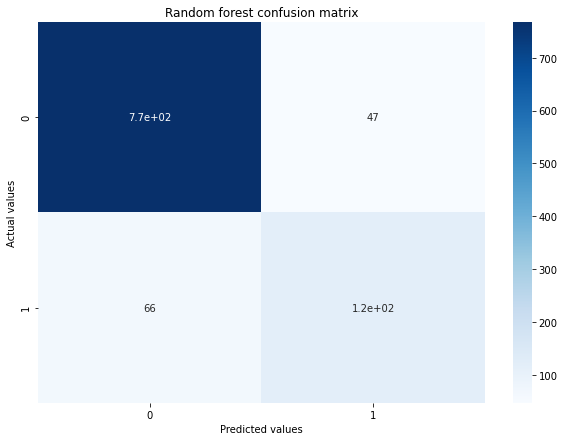

In [53]:
#Split the data into train, validation and test sets
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

#Standartization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

#Apply SMOTE
counter = Counter(Y_train)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)

#Implement the model
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_test,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_test,Y_pred))

Посмотрим какие переменные оказали наибольшее влияние при построении модели.

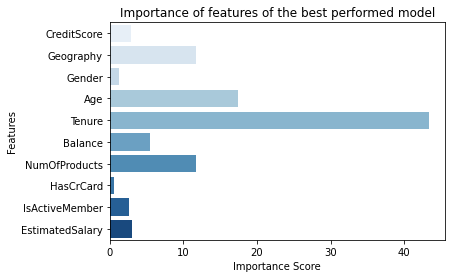

In [62]:
data1 = data.drop(['Exited'], axis = 'columns')

feature_imp = model_CBC.feature_importances_
sns.barplot(x = feature_imp, y = data1.columns, palette='Blues')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Importance of features of the best performed model')
plt.show()

Таким образом, наибольший вес имели:
- количество лет, в течение которых человек являлся клиентом банка;
- возраст;
- количество используемых продуктов;
- география;
- баланс на счёте.

Модель Catboost позволяет нам предсказать уход клиента с точностью 89%, F1 равным 0.68 и AUC-ROC score - 0.79. Эти показатели потенциально можно улучшить:

- применяя k-fold cross-validation;
- используя другие методики машинного обучения, например XGBoost;
- используя алгоритмы глубокого обучения, например ANN или LSTM;
- удалив одну или более малозначительных переменных;
- используя hyperparameters tuning.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*